In [ ]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install spacy
# !pip install wordcloud
# !pip install nltk
# !pip install tensorflow
# !pip install torch
# !pip install scikit-learn

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random


from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

# Data preprocessing & data visualization

In [56]:
df = pd.read_csv('twitter_training.csv')

In [57]:
df.sample(10)

,Index,Land,Mode,Text
1454,2654,Borderlands,Irrelevant,4 favorite game tracks:..........................
20869,12773,WorldOfCraft,Neutral,Live with Tuesday RAID NIGHT BABY... @ Warcraf...
56267,11256,TomClancysRainbowSix,Neutral,<unk>
21604,4098,CS-GO,Irrelevant,Feel like pure shit just want you an English t...
29448,664,ApexLegends,Positive,"After playing today, I’m gonna just say it......."
15366,3030,Dota2,Positive,soon i can finally enjoy watching melee again....
50995,6354,FIFA,Negative,& fuck fifa 20 too!! Stupid ass play.
1755,2708,Borderlands,Neutral,Borderlands 3 Voice Actor - Email & Email Shar...
70142,10818,TomClancysGhostRecon,Irrelevant,"Honors with a capital ""P."" No writing here, or..."
50870,6331,FIFA,Negative,"fuck yall 2k & fifa, bitch im playin orgeon trail"


In [58]:
print(f'The shape of the dataset is : {df.shape}')

The shape of the dataset is : (74682, 4)


In [19]:
print(f'The columns are :{df.columns}')

The columns are :Index(['Index', 'Land', 'Mode', 'Text'], dtype='object')


In [20]:
print(f'The dtypes of the dataset : \n\n{df.dtypes}')

The dtypes of the dataset : 

Index     int64
Land     object
Mode     object
Text     object
dtype: object


In [21]:
df.describe(include='all')

,Index,Land,Mode,Text
count,74682.000000,74682,74682,73996
unique,NaN,32,4,69491
top,NaN,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,NaN,2400,22542,172
mean,6432.586165,NaN,NaN,NaN
std,3740.427870,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN
25%,3195.000000,NaN,NaN,NaN
50%,6422.000000,NaN,NaN,NaN
75%,9601.000000,NaN,NaN,NaN


In [59]:
def show_details(dataset):
    missed_values = dataset.isnull().sum()
    missed_values_percent = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_percent = (dataset.duplicated().sum()) / len(dataset)
    info_frame = pd.DataFrame({'Missed_Values' : missed_values , 
                              'Missed_Values %' :missed_values_percent,
                              'Duplicated values' :duplicated_values,
                              'Duplicated values %':duplicated_values_percent})
    return info_frame.T

In [60]:
show_details(df)

,Index,Land,Mode,Text
Missed_Values,0.000000,0.000000,0.000000,686.000000
Missed_Values %,0.000000,0.000000,0.000000,0.009186
Duplicated values,2700.000000,2700.000000,2700.000000,2700.000000
Duplicated values %,0.036153,0.036153,0.036153,0.036153


In [61]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
show_details(df)

,Index,Land,Mode,Text
Missed_Values,0.0,0.0,0.0,0.0
Missed_Values %,0.0,0.0,0.0,0.0
Duplicated values,0.0,0.0,0.0,0.0
Duplicated values %,0.0,0.0,0.0,0.0


In [62]:
print(f'The number of unique lands : {len(df.Land.unique())}')
print('**' * 40)
df.Land.unique()

The number of unique lands : 32
********************************************************************************


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [63]:
lands =df.Land.value_counts()
lands.to_frame()

,count
Land,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


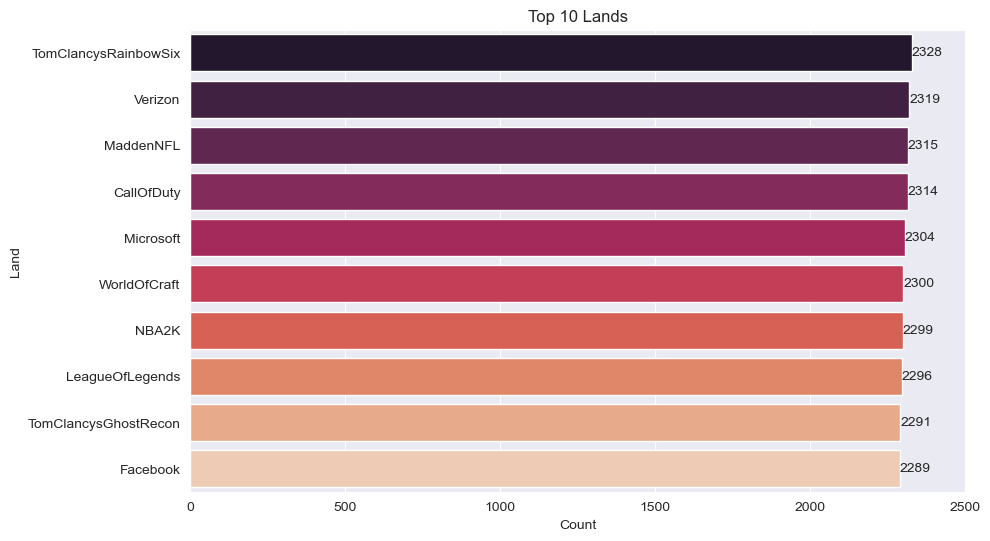

In [22]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,6))
bar = sns.barplot(x=lands.values[:10] ,y=lands.index[:10] , palette='rocket')
bar.bar_label(bar.containers[0])
plt.title('Top 10 Lands')
plt.xlabel('Count')
plt.ylabel('Land')
plt.xlim(0 , 2500)
plt.show()

In [64]:
print(f'The unique values of Mode : {len(df.Mode.unique())}')
print('**' * 20)
print(df.Mode.unique())

The unique values of Mode : 4
****************************************
['Positive' 'Neutral' 'Negative' 'Irrelevant']


In [31]:
mode = df.Mode.value_counts()
mode.to_frame().T

Mode,Negative,Positive,Neutral,Irrelevant
count,21698,19713,17708,12537


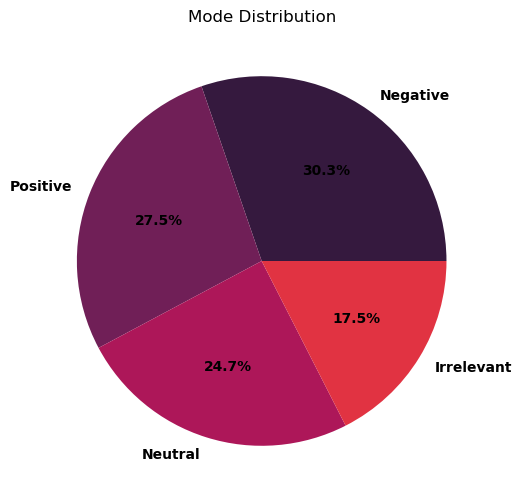

In [32]:
plt.figure(figsize=(6,6))
plt.pie(x = mode.values , labels=mode.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("rocket"))
plt.title('Mode Distribution') 
plt.show()

In [33]:
pd.crosstab(df.Mode , df.Land).T.style.background_gradient( subset=['Negative'],cmap='Reds')\
.background_gradient(subset=['Positive'] , cmap='Greens')\
.background_gradient(subset=['Irrelevant'] , cmap='BuGn')

Mode,Irrelevant,Negative,Neutral,Positive
Land,,,,
Amazon,185,565,1197,302
ApexLegends,185,574,913,606
AssassinsCreed,256,365,153,1382
Battlefield,907,445,342,561
Borderlands,238,415,581,972
CS-GO,620,335,523,717
CallOfDuty,660,861,367,426
CallOfDutyBlackopsColdWar,545,540,340,817
Cyberpunk2077,457,360,456,902


In [65]:
def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)
def text_cleaner(tx):                       # clean 
    
    text = re.sub(r"won\'t", "would not", tx)
    text = re.sub(r"im", "i am", tx)
    text = re.sub(r"Im", "I am", tx)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text

In [68]:
stopwords_list = stopwords.words('english')
print(f'There are {len(stopwords_list) } stop words')
print('**' * 20 , '\n20 of them are as follows:\n')
for inx , value in enumerate(stopwords_list[:20]):
    print(f'{inx+1}:{value}')

There are 179 stop words
**************************************** 
20 of them are as follows:

1:i
2:me
3:my
4:myself
5:we
6:our
7:ours
8:ourselves
9:you
10:you're
11:you've
12:you'll
13:you'd
14:your
15:yours
16:yourself
17:yourselves
18:he
19:him
20:his


In [69]:
def make_corpus(kind):
    corpus = []
    for text in df.loc[df['Mode']==kind]['Text'].str.split():
        for word in text:
            corpus.append(word)
    return corpus

In [72]:
Tokenizer=RegexpTokenizer(r'\w+')

In [73]:
# df['Text'] = df['Text'].apply(lambda x : clean_emoji(x))
df['Text'] = df['Text'].apply(lambda x : text_cleaner(x))
df['Text']= df['Text'].apply(lambda x : Tokenizer.tokenize(x))
df['Text'].to_frame()

,Text
0,"[im, getting, on, borderlands, and, i, will, m..."
1,"[i, am, coming, to, the, borders, and, i, will..."
2,"[im, getting, on, borderlands, and, i, will, k..."
3,"[im, coming, on, borderlands, and, i, will, mu..."
4,"[im, getting, on, borderlands, 2, and, i, will..."
...,...
74677,"[just, realized, that, the, windows, partition..."
74678,"[just, realized, that, my, mac, window, partit..."
74679,"[just, realized, the, windows, partition, of, ..."
74680,"[just, realized, between, the, windows, partit..."


In [74]:
# lemmatizer = WordNetLemmatizer() 
Stemmer = PorterStemmer()
def stopwords_cleaner(text):
#     word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    peasting = ' '.join(word)
    return peasting
df['Text'] = df['Text'].apply(lambda x : stopwords_cleaner(x))
# stopwords_cleaner(Tokenizer.tokenize(df.Text[100]))

In [75]:
df['Text'][:10].to_frame()

,Text
0,im get borderland murder
1,come border kill
2,im get borderland kill
3,im come borderland murder
4,im get borderland 2 murder
5,im get borderland murder
6,spent hour make someth fun know huge borderlan...
7,spent coupl hour someth fun know huge borderla...
8,spent hour someth fun know huge borderland fan...
9,spent hour make someth fun know huge rhandlerr...


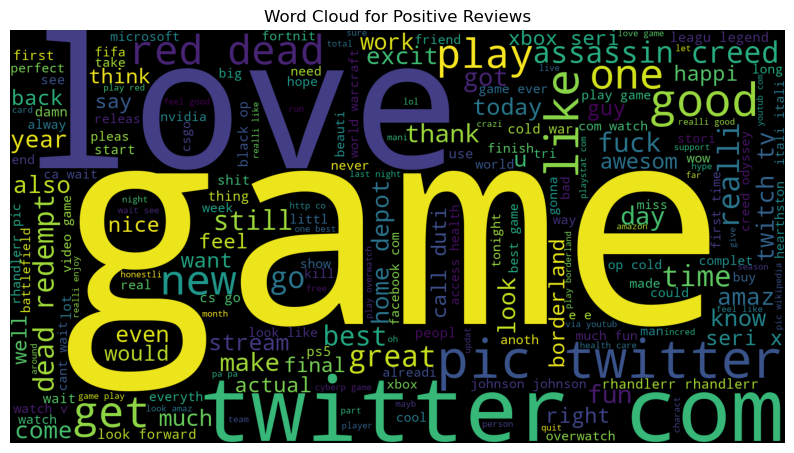

CPU times: total: 1.36 s
Wall time: 3.19 s


In [76]:
%%time
positive_reviews = df[df['Mode'] == 'Positive']['Text']
pos = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(pos)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

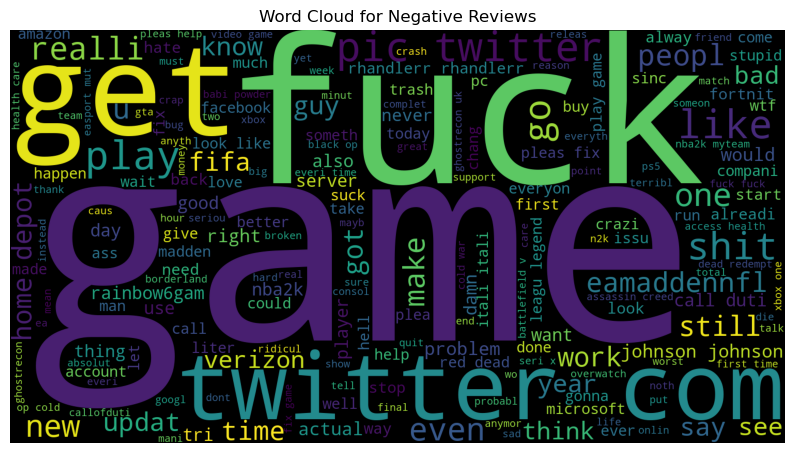

CPU times: total: 1.44 s
Wall time: 3.69 s


In [77]:
%%time
positive_reviews = df[df['Mode'] == 'Negative']['Text']
neg = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(neg)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

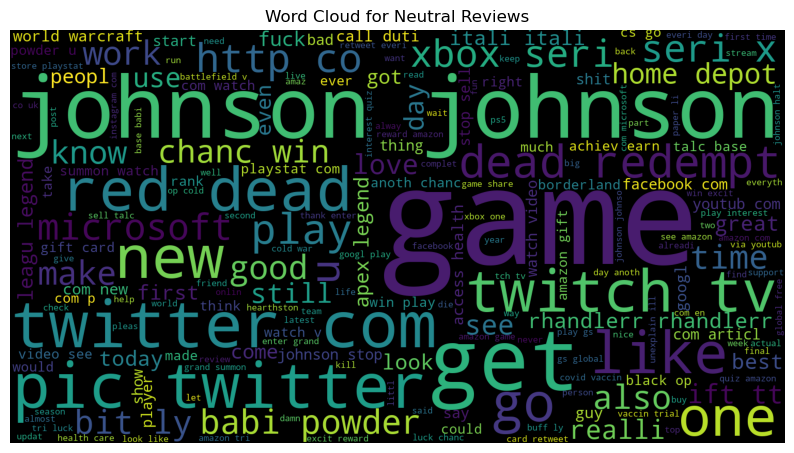

CPU times: total: 1.09 s
Wall time: 3.42 s


In [78]:
%%time
positive_reviews = df[df['Mode'] == 'Neutral']['Text']
Neutral = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Neutral)
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Neutral Reviews')
plt.axis('off')
plt.show()

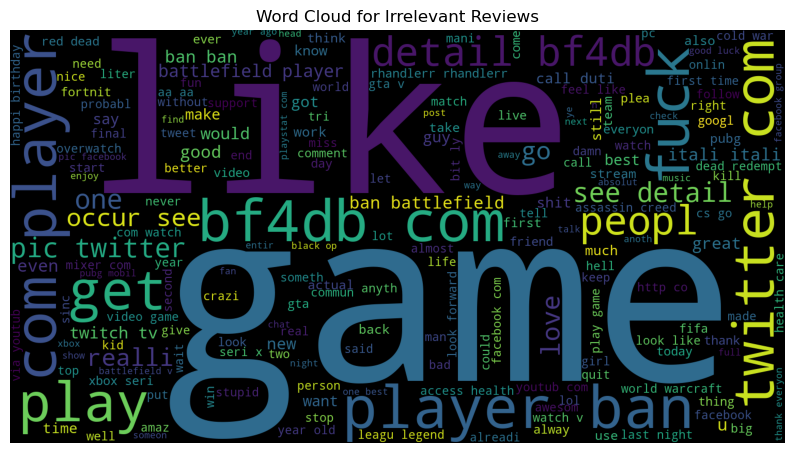

CPU times: total: 1.03 s
Wall time: 2.95 s


In [79]:
%%time
positive_reviews = df[df['Mode'] == 'Irrelevant']['Text']
Irrelevant  = ' '.join(map(str, positive_reviews))
pos_wordcloud = WordCloud(width=1500, height=800,
                          background_color='black',
                         stopwords=stopwords_list,
                          min_font_size=15).generate(Irrelevant )
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud)
plt.title('Word Cloud for Irrelevant Reviews')
plt.axis('off')
plt.show()

In [80]:
len_text = [len(tx) for tx in df['Text'].to_list()]
print(f'Max Length : {np.max(len_text)}')
print(f'Min Length : {np.min(len_text)}')
print(f'Mean Length : {round(np.mean(len_text),2)}')
print(f'Std Length : {round(np.std(len_text),2)}')
print(f'Mew + 2sigma : {round(np.mean(len_text)+ 2 *np.std(len_text),2)}')

Max Length : 797
Min Length : 0
Mean Length : 67.66
Std Length : 49.0
Mew + 2sigma : 165.65


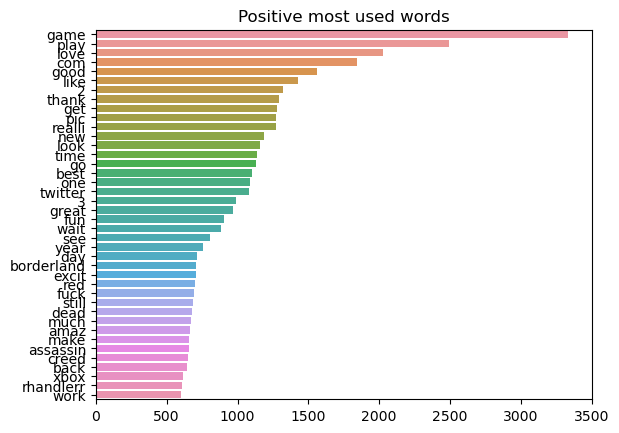

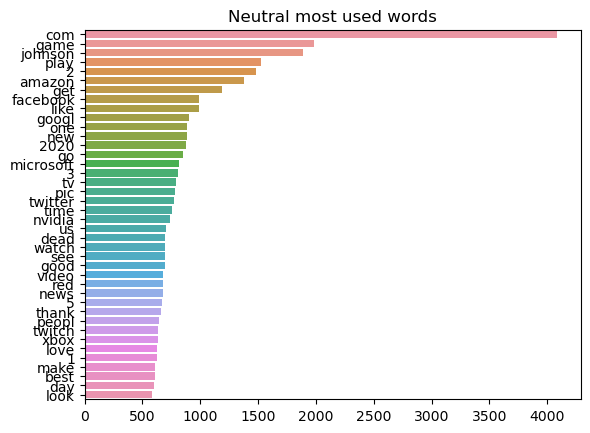

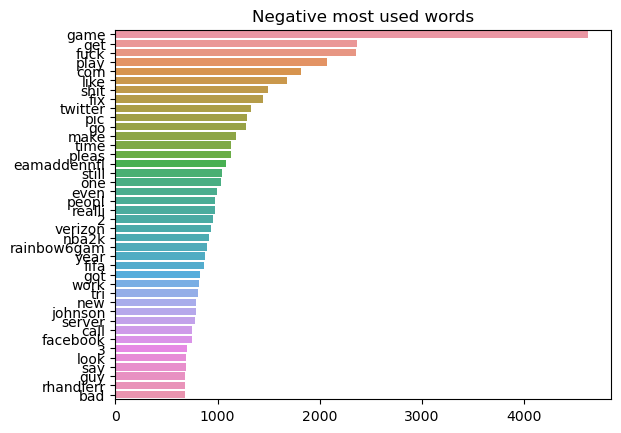

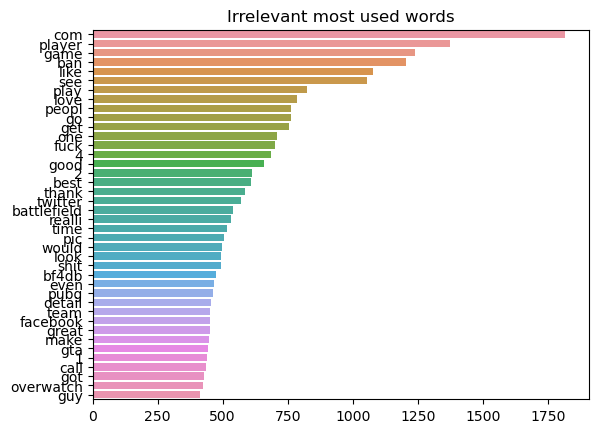

CPU times: total: 438 ms
Wall time: 2.19 s


In [81]:
%%time
for inx , value in enumerate(sentiments):
    
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)
         
    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

In [83]:
df['sentiments'] = df['Mode'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 3 })

In [84]:
df.sample(10)

,Index,Land,Mode,Text,sentiments
46922,5651,HomeDepot,Neutral,home depot worker pasadena die heart attack,2
52666,10647,RedDeadRedemption(RDR),Positive,feel bad peopl get die stuff come talk like go...,1
73881,9057,Nvidia,Positive,love letter,1
48499,5926,HomeDepot,Neutral,stop theyr steal girl hous depot byeehebsbsh,2
9186,9579,Overwatch,Negative,embarrass overwatch moment pic twitter com v0x...,0
55818,2382,CallOfDuty,Irrelevant,vote one action ask citizen answer call duti t...,3
33704,6589,Fortnite,Negative,switch bennitegam mwmodernwarfar bc epic noth,0
50087,6197,FIFA,Positive,greatest center forward game produc,1
27260,1091,AssassinsCreed,Positive,whenev step away photographi alway seem like o...,1
68325,3700,Cyberpunk2077,Positive,game wait,1


# Model Training

In [85]:
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [88]:
def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

In [89]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

In [90]:
class sentimentBiLSTM(nn.Module):
#inherited from nn.Module
    
    def __init__(self, embedding_matrix, hidden_dim, output_size):
      
        #initializing the params by initialization method 
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        # craetinh embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        
        ## initializes the weights of the embedding layer to the pretrained embeddings in 
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and 
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)

        #it is multuplied by 2 becuase it is bi_directional if one-sided it didnt need.
        self.fc = nn.Linear(hidden_dim*2, output_size)
        

    #we need a forward function to model calculate the cost and know how bad the params is .  
    # However , it can be written in a line of code but if we want to track it it is easier way.  
    def forward(self, x):

       
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

In [102]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 4


if torch.cuda.is_available():
    
       device = torch.device("cuda")
   
else:
       device = torch.device("cpu")
    

print(f'Current device is {device}')

Current device is cpu


In [103]:
y = df.sentiments.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Text.values.tolist())

xtrain = tokenizer.texts_to_sequences(train_df.Text.values)
xtest = tokenizer.texts_to_sequences(test_df.Text.values)
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)
train_dataset = Dataset(text=xtrain,sentiment=train_df.sentiments.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.sentiments.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)

In [104]:
# check a batch of data 
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[    0,     0,     0,  ...,  3169,  3660,  3493],
         [    0,     0,     0,  ...,  3544,   757,   618],
         [    0,     0,     0,  ...,  1093, 12233,   130],
         ...,
         [    0,     0,     0,  ...,  8366,   153,   122],
         [    0,     0,     0,  ...,   106,   738,  1327],
         [    0,     0,     0,  ...,     2,     1,  9948]]),
 'target': tensor([0, 2, 0, 2, 3, 0, 3, 3, 3, 0, 1, 0, 0, 1, 2, 0, 3, 0, 1, 2, 2, 3, 1, 2,
         1, 1, 0, 1, 0, 3, 1, 1])}

In [105]:
embedding_dict = load_vectors('glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [106]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23588, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)


In [107]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 
# schedul_learning = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer , milestones=[6] ,
#                                                         gamma=0.055)

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

In [108]:
clip = 5
epochs = 9
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    # for getting loss and accuracy for train
    train_losses = []
    train_acc = 0.0

    #put model on train mode
    model.train()
    correct = 0

    # initialize hidden state 
    for data in train_loader:  

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

         #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)
          # calculate the loss and perform backprop
        loss = criterion(output, labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # for getting loss and accuracy for valiadtion
    val_losses = []
    val_acc = 0.0

    #put model on evaluation mode
    model.eval()
    for data in valid_loader:

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

        #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
        #Loss calculating 
        val_loss = criterion(output, labels.long())
        #append Loss to the above list
        val_losses.append(val_loss.item())

        # calculating accuracy 
        accuracy = acc(output,labels)
        val_acc += accuracy
        epoch_train_loss = np.mean(train_losses)

        #using schedule lr if you need
#         schedul_learning.step()
#         schedul_learning

    #appending all accuracy and loss to the above lists and variables
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #each time that model(params) get better you can save the model(you have to enter a path ou you pc and save with pt file)
        # torch.save(model.state_dict(), r'C:\Users\payama\Desktop\Projects kaggle\NLP\vectors features\BidirectionalLSTM.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        # save model if better result happends
        valid_loss_min = epoch_val_loss
    print(30 * '==' , '>')

Epoch 1
train_loss : 1.1001192702719913 val_loss : 0.9820670022793797
train_accuracy : 53.02839997208848 val_accuracy : 58.90315378174714
Validation loss decreased (inf --> 0.9820670022793797)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.8565522360775073 val_loss : 0.8433181800831617
train_accuracy : 65.50833856674342 val_accuracy : 66.34803237510467
Validation loss decreased (0.9820670022793797 --> 0.8433181800831617)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.6709395568341533 val_loss : 0.7570076668155806
train_accuracy : 73.96901821226712 val_accuracy : 70.5623778956182
Validation loss decreased (0.8433181800831617 --> 0.7570076668155806)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.5336433213343506 val_loss : 0.6759095030276301
train_accuracy : 79.90370525434372 val_accuracy : 74.25341892269049
Validation 

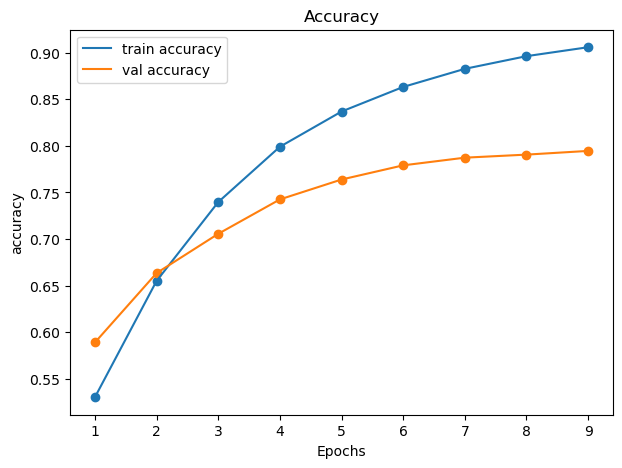

In [109]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

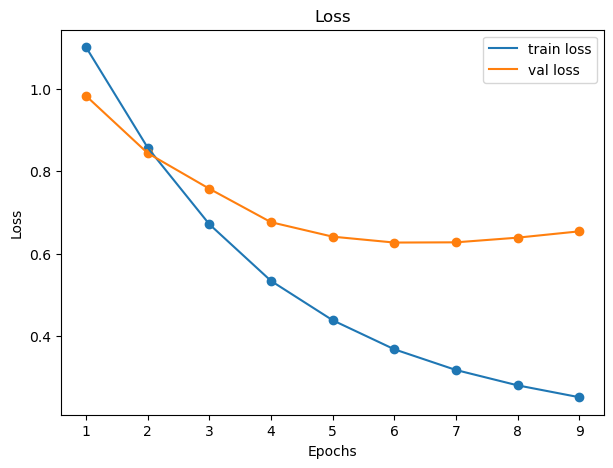

In [110]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()